In [1]:
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import warnings
import time

In [2]:
# Ignore warnings
warnings.filterwarnings("ignore")

**Loading Data**

In [3]:
df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Exploratory Data Analysis (EDA)**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

**Text Length Analysis**

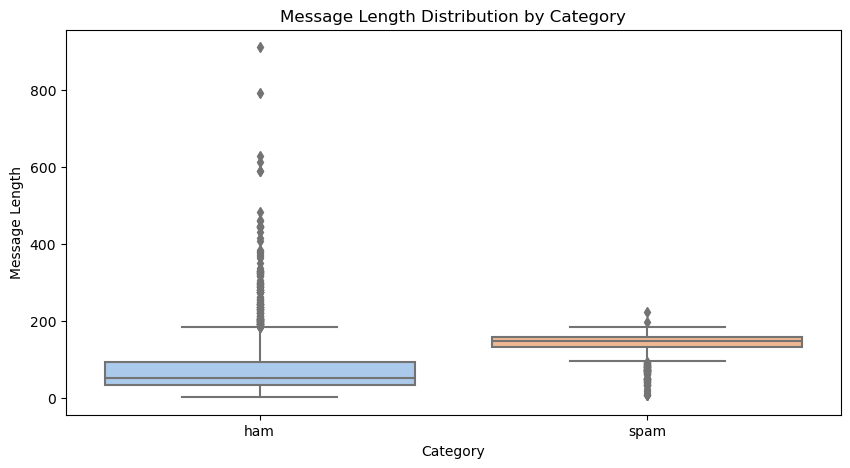

In [7]:


df['Message_Length'] = df['Message'].str.len()  # Calculate the length of each message

plt.figure(figsize=(10, 5))
sns.boxplot(x='Category', y='Message_Length', data=df, palette='pastel')
plt.title('Message Length Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Message Length')
plt.show()






**Common Words in Messages**

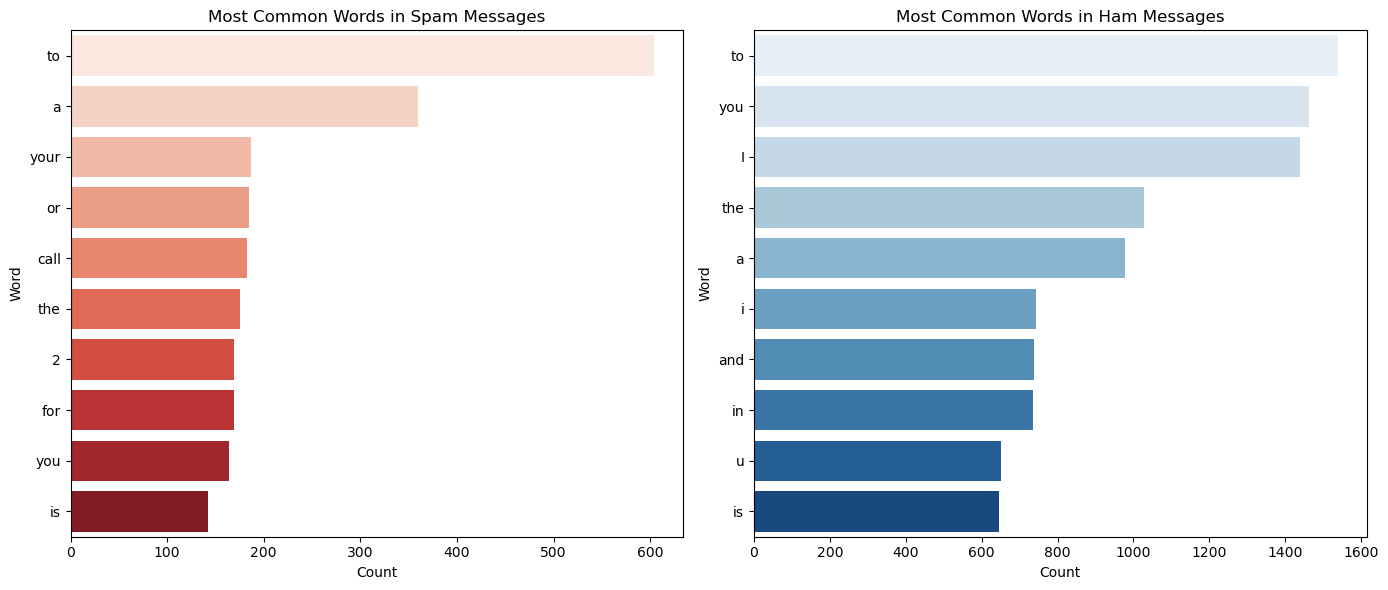

In [8]:
from collections import Counter

# Tokenize messages and count words
spam_words = ' '.join(df[df['Category'] == 'spam']['Message']).split()
ham_words = ' '.join(df[df['Category'] == 'ham']['Message']).split()

spam_word_counts = Counter(spam_words)
ham_word_counts = Counter(ham_words)

# Get the most common words
spam_common_words = spam_word_counts.most_common(10)
ham_common_words = ham_word_counts.most_common(10)

# Convert to DataFrame for better visualization
spam_df = pd.DataFrame(spam_common_words, columns=['Word', 'Count'])
ham_df = pd.DataFrame(ham_common_words, columns=['Word', 'Count'])

# %% [markdown]
# **Visualizing Common Words**

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Word', data=spam_df, palette='Reds')
plt.title('Most Common Words in Spam Messages')

plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Word', data=ham_df, palette='Blues')
plt.title('Most Common Words in Ham Messages')

plt.tight_layout()
plt.show()




**Check for Duplicates**

In [9]:

duplicates = df.duplicated().sum()
print(f"Number of duplicate entries in the dataset: {duplicates}")

Number of duplicate entries in the dataset: 415


**Data Preprocessing:**

In [10]:
df['Message'] = df['Message'].str.lower()

# Removing '#' tag, '@', URLs, and punctuations
df['Message'] = df['Message'].str.replace('#','').str.replace('@','').str.replace(r'^https?:\/\/.*[\r\n]*','', regex=True).str.translate(str.maketrans('', '', string.punctuation))

# Encoding category column
df['spam'] = df['Category'].apply(lambda x: 1 if x=='spam' else 0)

In [11]:
df.head()

,Category,Message,Message_Length,spam
0,ham,go until jurong point crazy available only in ...,111,0
1,ham,ok lar joking wif u oni,29,0
2,spam,free entry in 2 a wkly comp to win fa cup fina...,155,1
3,ham,u dun say so early hor u c already then say,49,0
4,ham,nah i dont think he goes to usf he lives aroun...,61,0


**Convert Text Data to Numerical Data**

In [12]:
cv = CountVectorizer()
X = cv.fit_transform(df['Message']).toarray()
Y = df['spam']

**Train Test Split**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

**Best First Feature Selection**

In [14]:

def best_first_feature_selection(X_train, y_train, X_test, y_test):
    selected_features = []  # Initialize empty list for selected features
    best_accuracy = 0  # Start with 0 accuracy
    
    num_features = X_train.shape[1]
    
    # Keep going until no more features can improve the accuracy
    while True:
        improved = False  # Track if we've improved
        for feature_idx in range(num_features):
            if feature_idx not in selected_features:  # Only consider unselected features
                # Create a temporary list of selected features
                temp_features = selected_features + [feature_idx]
                
                # Train a model with the selected features
                model = DecisionTreeClassifier(criterion='entropy', max_depth=5)
                model.fit(X_train[:, temp_features], y_train)
                predictions = model.predict(X_test[:, temp_features])
                
                # Calculate accuracy
                accuracy = accuracy_score(y_test, predictions)
                
                # Check if we have a new best feature
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    selected_features = temp_features  # Update selected features
                    improved = True  # We made an improvement
                    print(f"Improved with feature {feature_idx}, new accuracy: {best_accuracy:.4f}")
        
        # If no improvement was made, we are done
        if not improved:
            break
            
    return selected_features

# Call the function to get selected features
selected_indices = best_first_feature_selection(X_train, y_train, X_test, y_test)
selected_feature_names = cv.get_feature_names_out()[selected_indices]
print(f"Selected Features:\n{selected_feature_names}")

Improved with feature 0, new accuracy: 0.8684
Improved with feature 4, new accuracy: 0.8690
Improved with feature 7, new accuracy: 0.8696
Improved with feature 8, new accuracy: 0.8702
Improved with feature 14, new accuracy: 0.8708
Improved with feature 48, new accuracy: 0.8726
Improved with feature 51, new accuracy: 0.8744
Improved with feature 52, new accuracy: 0.8786
Improved with feature 91, new accuracy: 0.8792
Improved with feature 103, new accuracy: 0.8798
Improved with feature 289, new accuracy: 0.8840
Improved with feature 290, new accuracy: 0.8864
Improved with feature 335, new accuracy: 0.8882
Improved with feature 351, new accuracy: 0.8971
Improved with feature 357, new accuracy: 0.8995
Improved with feature 372, new accuracy: 0.9001
Improved with feature 685, new accuracy: 0.9025
Improved with feature 1443, new accuracy: 0.9037
Improved with feature 2237, new accuracy: 0.9073
Improved with feature 2241, new accuracy: 0.9109
Improved with feature 2583, new accuracy: 0.9139
I

**Model Evaluation Function**

In [15]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    start_time = time.time()  # Start time measurement
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    end_time = time.time()  # End time measurement
    
    accuracy = accuracy_score(y_test, predictions)
    error_rate = 1 - accuracy
    execution_time = end_time - start_time
    
    return accuracy, error_rate, execution_time, predictions


**Model Training**

**Model 1: J48**

Decision Tree (J48) with Selected Features Accuracy: 95.22%
Decision Tree (J48) with Selected Features Error Rate: 4.78%
Decision Tree (J48) with Selected Features Execution Time: 0.0100 seconds


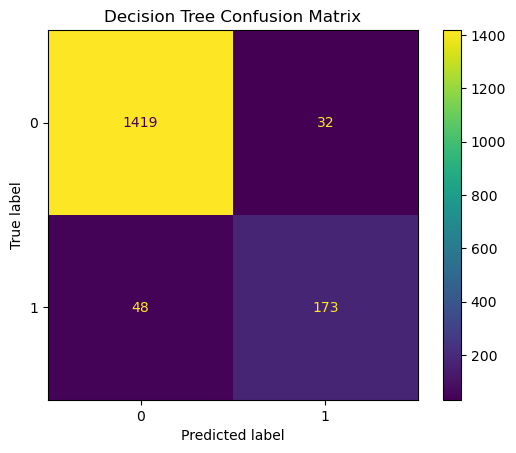

In [16]:
# Initialize the model
J48_like = DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Evaluate model with selected features using the evaluation function
J48_accuracy_selected, J48_error_rate_selected, J48_execution_time_selected, J48_pred = evaluate_model(J48_like, X_train[:, selected_indices], y_train, X_test[:, selected_indices], y_test)

# Print results
print(f"Decision Tree (J48) with Selected Features Accuracy: {J48_accuracy_selected * 100:.2f}%")
print(f"Decision Tree (J48) with Selected Features Error Rate: {J48_error_rate_selected * 100:.2f}%")
print(f"Decision Tree (J48) with Selected Features Execution Time: {J48_execution_time_selected:.4f} seconds")

# Confusion Matrix
J48_confusion = confusion_matrix(y_test, J48_pred)
display = ConfusionMatrixDisplay(confusion_matrix=J48_confusion, display_labels=[0, 1])
display.plot()
plt.title('Decision Tree Confusion Matrix')
plt.show()

**Model 2: Naive Bayes**


Gaussian Naive Bayes Accuracy: 94.56%
Gaussian Naive Bayes Error Rate: 5.44%
Gaussian Naive Bayes Execution Time: 0.0127 seconds


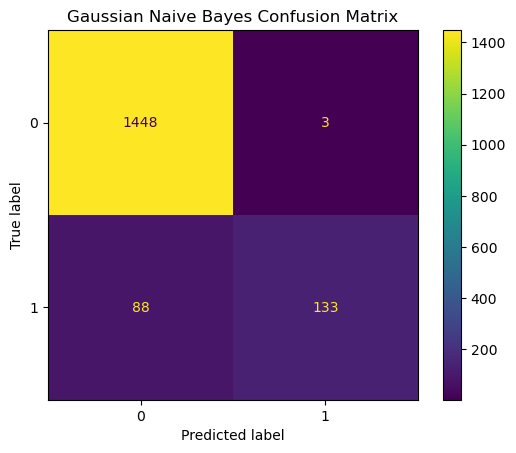

In [17]:
# Initialize the model
NB = GaussianNB()

# Evaluate model with selected features using the evaluation function
NB_accuracy, NB_error_rate, NB_execution_time, NB_pred = evaluate_model(NB, X_train[:, selected_indices], y_train, X_test[:, selected_indices], y_test)

# Print results
print(f"Gaussian Naive Bayes Accuracy: {NB_accuracy * 100:.2f}%")
print(f"Gaussian Naive Bayes Error Rate: {NB_error_rate * 100:.2f}%")
print(f"Gaussian Naive Bayes Execution Time: {NB_execution_time:.4f} seconds")

# Confusion Matrix
NB_confusion = confusion_matrix(y_test, NB_pred)
display = ConfusionMatrixDisplay(confusion_matrix=NB_confusion, display_labels=[0, 1])
display.plot()
plt.title('Gaussian Naive Bayes Confusion Matrix')
plt.show()


 **Model 3: Naive Bayes Multinomial**

Multinomial Naive Bayes Accuracy: 96.17%
Multinomial Naive Bayes Error Rate: 3.83%
Multinomial Naive Bayes Execution Time: 0.0212 seconds


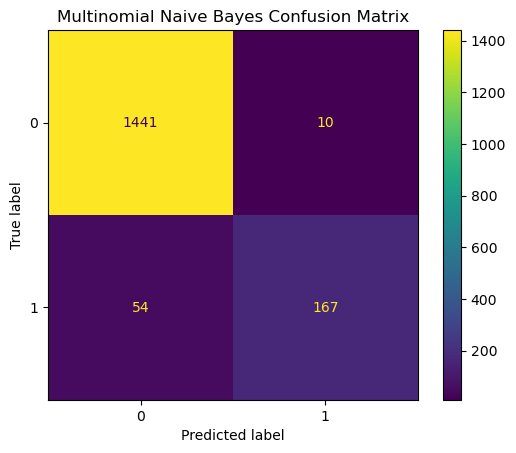

In [18]:
MNB = MultinomialNB()

# Evaluate model with selected features using the evaluation function
MNB_accuracy, MNB_error_rate, MNB_execution_time, MNB_pred = evaluate_model(MNB, X_train[:, selected_indices], y_train, X_test[:, selected_indices], y_test)

# Print results
print(f"Multinomial Naive Bayes Accuracy: {MNB_accuracy * 100:.2f}%")
print(f"Multinomial Naive Bayes Error Rate: {MNB_error_rate * 100:.2f}%")
print(f"Multinomial Naive Bayes Execution Time: {MNB_execution_time:.4f} seconds")

# Confusion Matrix
MNB_confusion = confusion_matrix(y_test, MNB_pred)
display = ConfusionMatrixDisplay(confusion_matrix=MNB_confusion, display_labels=[0, 1])
display.plot()
plt.title('Multinomial Naive Bayes Confusion Matrix')
plt.show()

**Comparison**

In [19]:
# Summary of results
results = {
    "Model": ["Decision Tree (J48)", "Gaussian Naive Bayes", "Multinomial Naive Bayes"],
    "Accuracy (%)": [J48_accuracy_selected * 100, NB_accuracy * 100, MNB_accuracy * 100],
    "Error Rate (%)": [J48_error_rate_selected * 100, NB_error_rate * 100, MNB_error_rate * 100],
    "Execution Time (s)": [J48_execution_time_selected, NB_execution_time, MNB_execution_time],
}

results_df = pd.DataFrame(results)
print(results_df)


                     Model  Accuracy (%)  Error Rate (%)  Execution Time (s)
0      Decision Tree (J48)     95.215311        4.784689            0.010005
1     Gaussian Naive Bayes     94.557416        5.442584            0.012660
2  Multinomial Naive Bayes     96.172249        3.827751            0.021218


In [20]:

best_model = results_df[results_df['Accuracy (%)'] == results_df['Accuracy (%)'].max()]

print("Best Performing Model:")
print(best_model)


Best Performing Model:
                     Model  Accuracy (%)  Error Rate (%)  Execution Time (s)
2  Multinomial Naive Bayes     96.172249        3.827751            0.021218


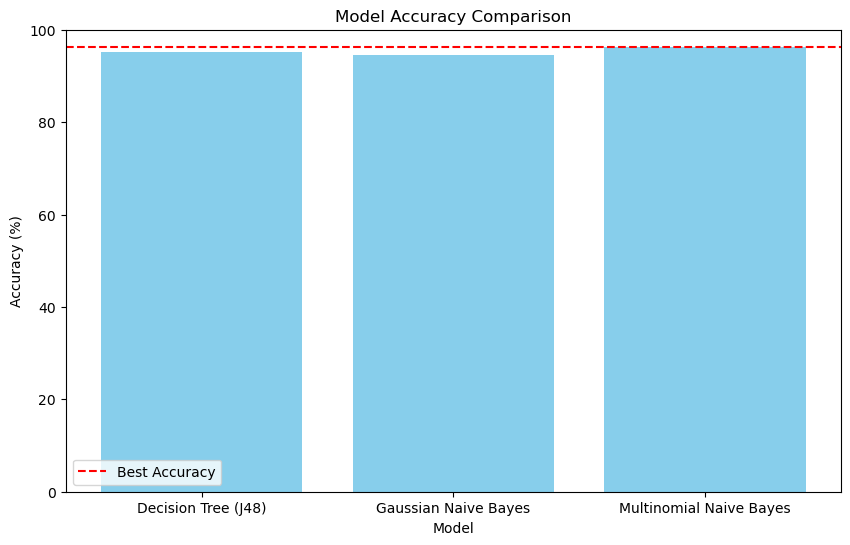

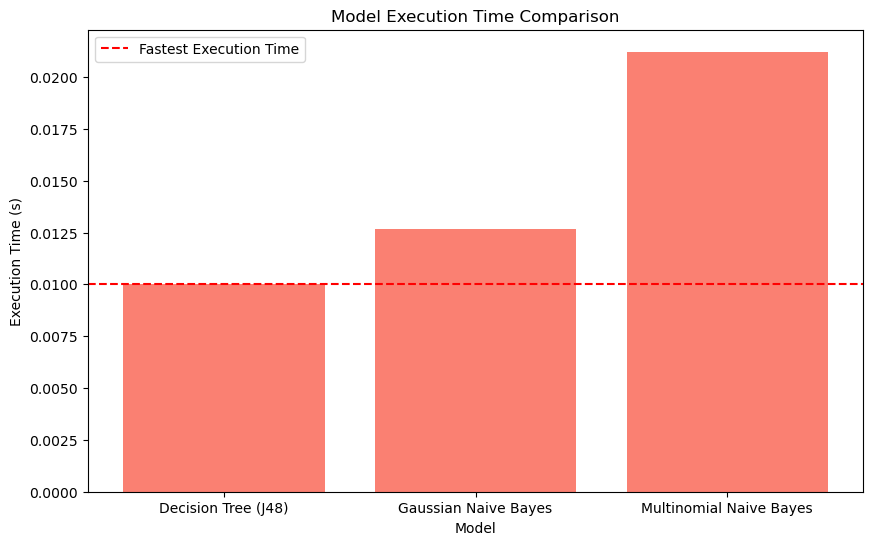

In [21]:

# Bar plot for accuracy
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Accuracy (%)'], color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 100])
plt.axhline(y=results_df['Accuracy (%)'].max(), color='r', linestyle='--', label='Best Accuracy')
plt.legend()
plt.show()

# Bar plot for execution time
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Execution Time (s)'], color='salmon')
plt.xlabel('Model')
plt.ylabel('Execution Time (s)')
plt.title('Model Execution Time Comparison')
plt.axhline(y=results_df['Execution Time (s)'].min(), color='r', linestyle='--', label='Fastest Execution Time')
plt.legend()
plt.show()
